# **Exploratory Data Analysis (EDA) for Portfolio Management**

This notebook provides a comprehensive exploratory data analysis of the financial time series data for the assets TSLA, SPY, and BND. The primary goal is to understand the characteristics of the data, including trends, volatility, stationarity, and risk, to inform the subsequent portfolio optimization and time series forecasting steps.

## **1. Setup and Data Loading**

First, we will set up the environment by importing necessary libraries and loading the preprocessed data from the `data/processed` directory. We'll use our custom `load_processed_data` function from the `eda.py` script.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from statsmodels.tsa.stattools import adfuller

# Add the project root to the path for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.EDA.eda import load_processed_data

# Load the processed data
processed_dfs = load_processed_data()
if not processed_dfs:
    raise FileNotFoundError("Processed data not found. Please run src/data_preprocessor.py first.")

Loaded processed data for SPY. Shape: (2534, 7)
Loaded processed data for TSLA. Shape: (2534, 7)
Loaded processed data for BND. Shape: (2534, 7)


#### Analysis of Output
This output confirms that the `load_processed_data` function successfully found and loaded the preprocessed data for all three assets (SPY, TSLA, and BND) from the `data/processed` directory. Each DataFrame has a consistent shape of **(2534, 7)**, meaning they contain 2534 rows (days) and 7 columns, which is a good indicator of data integrity and consistency across the assets.

## **2. Data Inspection and Summarization**

We will perform a basic inspection of the preprocessed data to understand its structure, check for missing values, and view summary statistics.

In [9]:
for ticker, df in processed_dfs.items():
    print(f"--- Data Information for {ticker} ---")
    df.info()
    print(f"\n--- Summary Statistics for {ticker} ---")
    print(df.describe())

--- Data Information for SPY ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2534 entries, 2015-07-02 to 2025-07-30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2534 non-null   float64
 1   High          2534 non-null   float64
 2   Low           2534 non-null   float64
 3   Close         2534 non-null   float64
 4   Volume        2534 non-null   int64  
 5   daily_return  2534 non-null   float64
 6   Close_scaled  2534 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 158.4 KB

--- Summary Statistics for SPY ---
              Open         High          Low        Close        Volume  \
count  2534.000000  2534.000000  2534.000000  2534.000000  2.534000e+03   
mean    334.256588   336.045003   332.176983   334.188290  8.501510e+07   
std     126.413035   127.038072   125.646866   126.376581  4.428513e+07   
min     155.869751   156.926731   153.758485   155.426500  2.027000e

#### Analysis of Output
The `.info()` output for all three assets confirms that there are **no missing values**, and the data types are correct (`float64` for prices and returns, `int64` for volume). This is critical, as it means the data is clean and ready for analysis and modeling. The `DatetimeIndex` is also properly set, ensuring our time-series operations will work correctly.

The `.describe()` output provides valuable insights into each asset's characteristics:

* **SPY (S&P 500 ETF)**: Shows a strong upward trend over the period, with a wide range between the minimum and maximum closing prices. The `daily_return` standard deviation (0.011) indicates a moderate level of volatility compared to TSLA.
* **TSLA (Tesla)**: The statistics for TSLA reveal a highly volatile and fast-growing stock. Its mean closing price is lower than SPY, but the standard deviation (0.039) for its `daily_return` is significantly higher, almost four times that of SPY. The maximum daily return is also notably larger, highlighting its explosive growth and higher risk.
* **BND (Vanguard Bond ETF)**: This asset exhibits a very low mean and standard deviation for its `daily_return` (0.000077 and 0.003276, respectively). This is expected for a bond fund, which is designed to be a low-volatility, low-risk investment, acting as a stable component in a diversified portfolio.

## **3. Temporal Analysis: Price and Returns Visualization**

The core of our EDA is to visualize the time series. This helps us identify trends, seasonality, and sudden shocks. We will plot the close prices and the daily percentage change (returns).

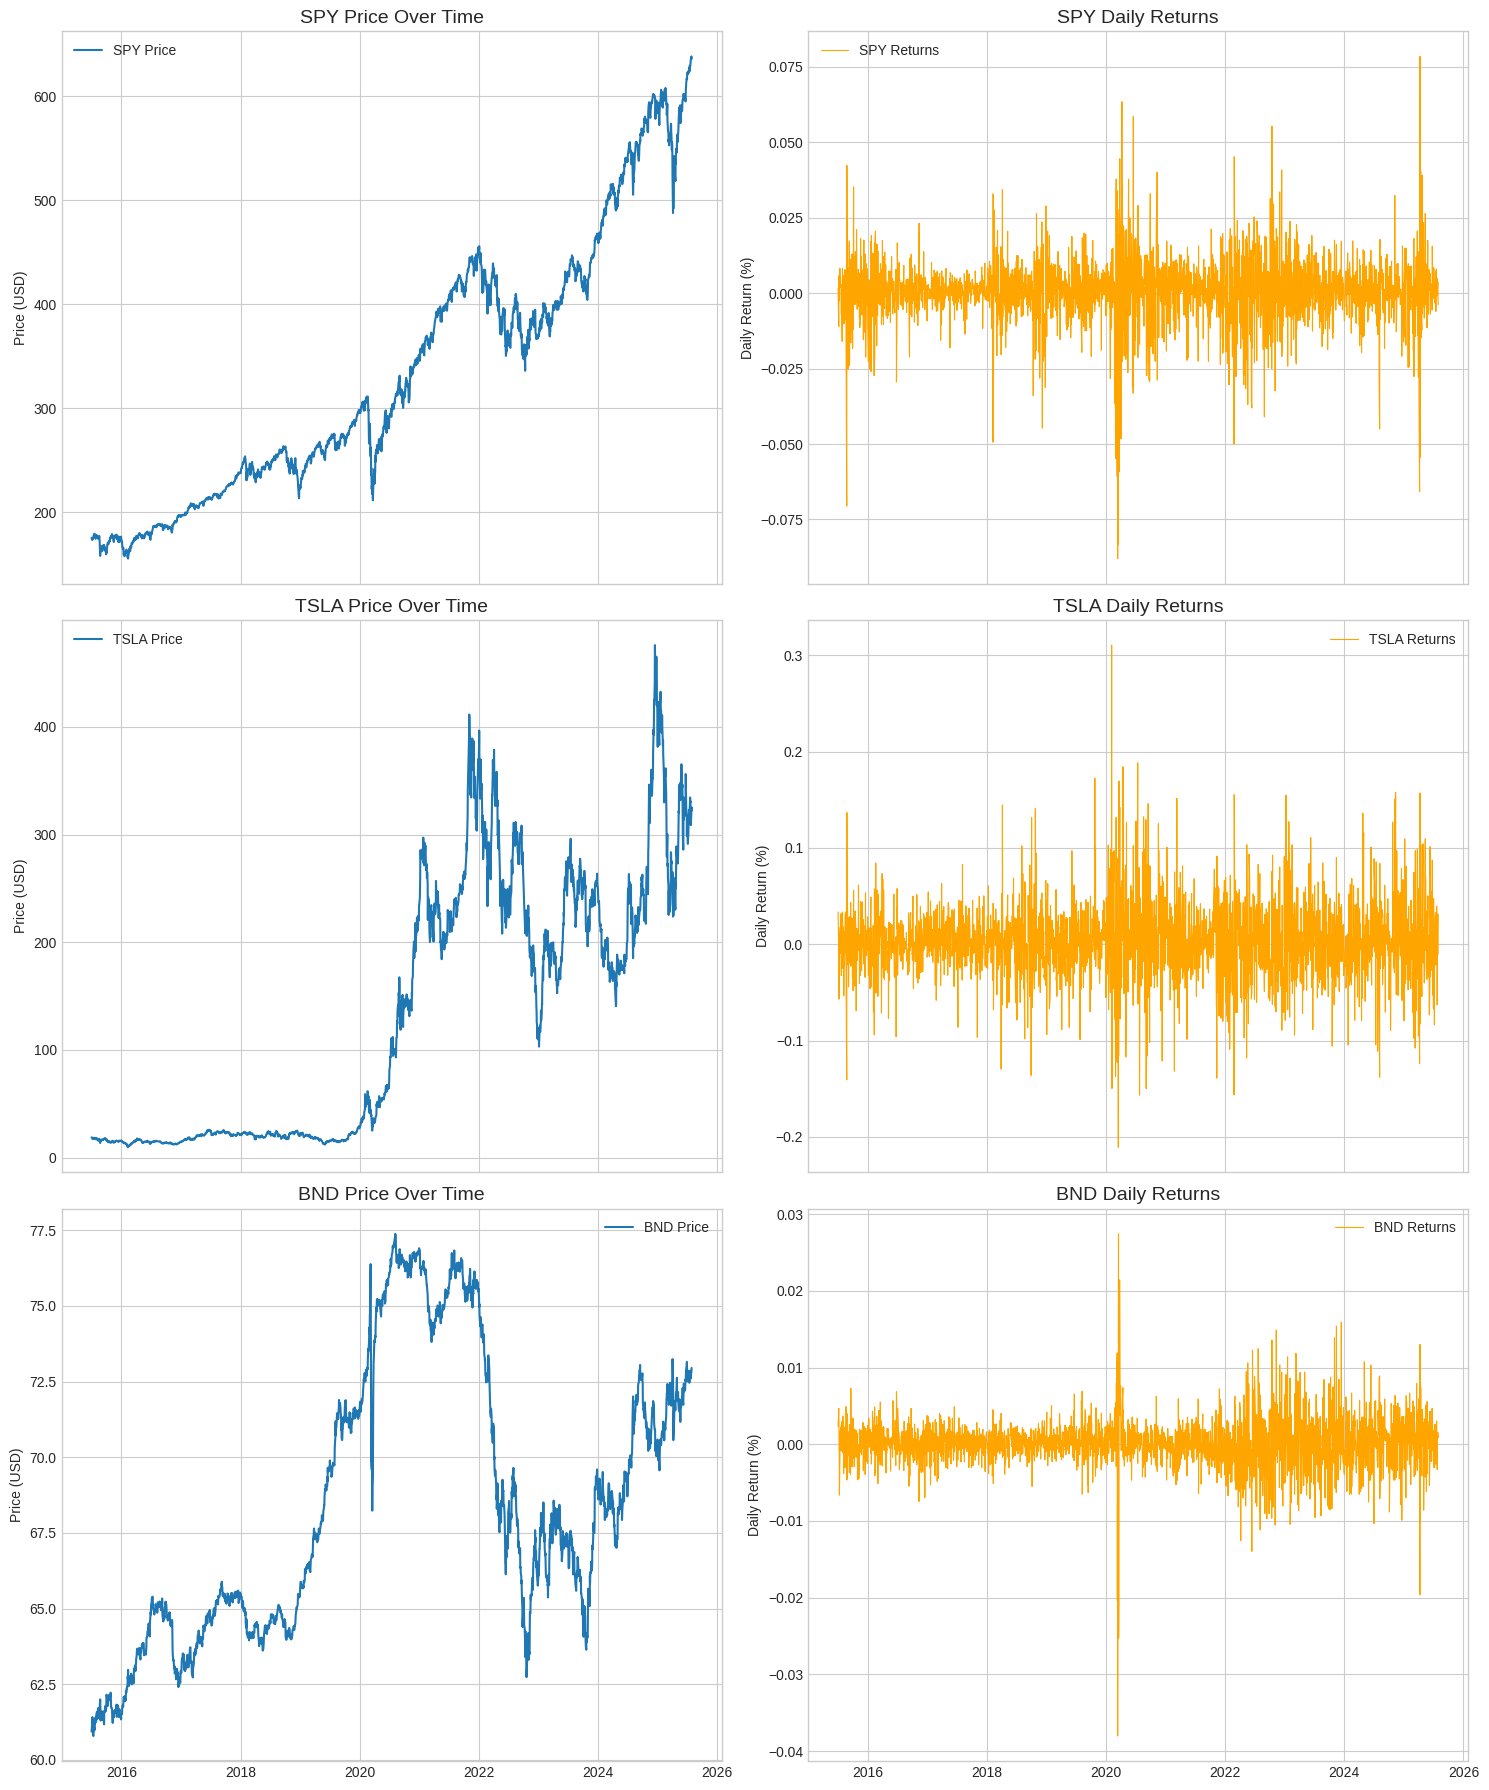

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(len(processed_dfs), 2, figsize=(15, 6 * len(processed_dfs)), sharex=True)

for i, (ticker, df) in enumerate(processed_dfs.items()):
    # Plot Price over time
    ax_price = axes[i, 0]
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    ax_price.plot(df.index, df[price_col], label=f'{ticker} Price', linewidth=1.5)
    ax_price.set_title(f'{ticker} Price Over Time', fontsize=14)
    ax_price.set_ylabel('Price (USD)')
    ax_price.legend()
    ax_price.grid(True)

    # Plot Daily Returns
    ax_returns = axes[i, 1]
    ax_returns.plot(df.index, df['daily_return'], label=f'{ticker} Returns', linewidth=0.8, color='orange')
    ax_returns.set_title(f'{ticker} Daily Returns', fontsize=14)
    ax_returns.set_ylabel('Daily Return (%)')
    ax_returns.legend()
    ax_returns.grid(True)

plt.tight_layout()
plt.show()

#### Analysis of Output
The price plots show distinct trends for each asset:

* **TSLA and SPY** show a clear, upward trend over the entire period, indicating they are growth-oriented assets. The price series are non-stationary, as they do not fluctuate around a constant mean. This confirms our initial hypothesis that these time series will require differencing before they can be modeled with techniques that assume stationarity, like ARIMA.
* **BND** shows a much flatter, more stable price movement, as expected from a bond fund. However, even this series likely has a trend component, meaning it is also non-stationary.

The returns plots provide a different perspective:

* The `daily_return` series for all assets appears to be **stationary**, fluctuating around a mean of zero. This is a key characteristic for time series analysis.
* All three plots, especially for TSLA and SPY, exhibit **volatility clustering**, where periods of high volatility (large swings in returns) are grouped together. This is a common feature of financial data and is a critical insight for modeling. BND shows a much tighter distribution of returns, consistent with its low-risk nature.

## **4. Volatility Analysis**

We will analyze volatility by calculating and plotting the rolling mean and standard deviation of daily returns. This helps us to see how volatility changes over time, revealing periods of high fluctuation often associated with market events.

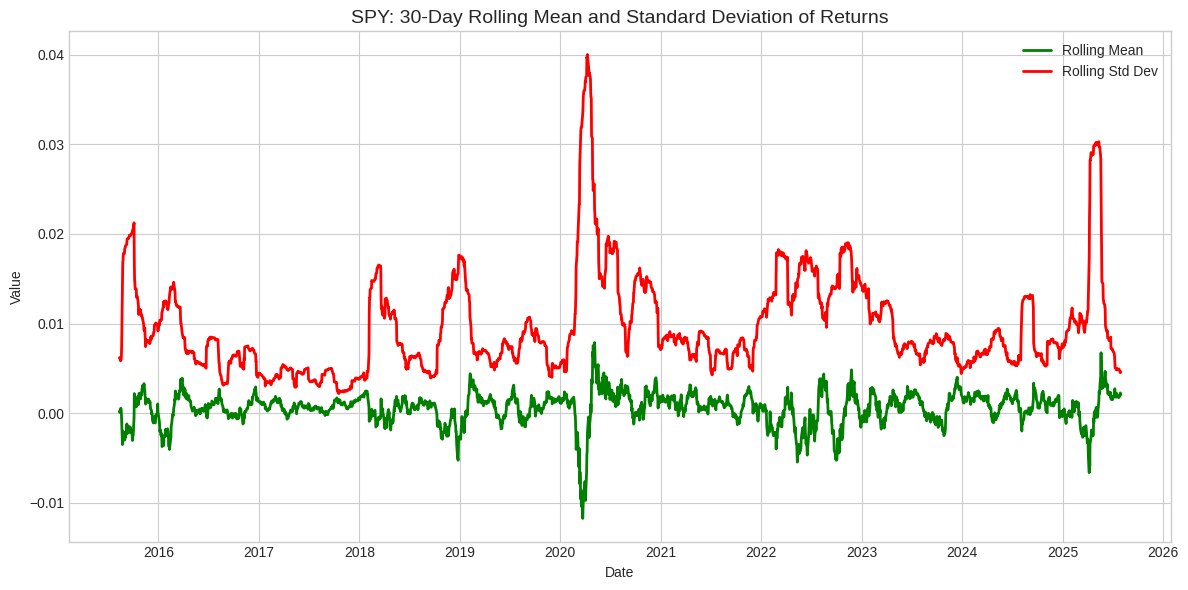

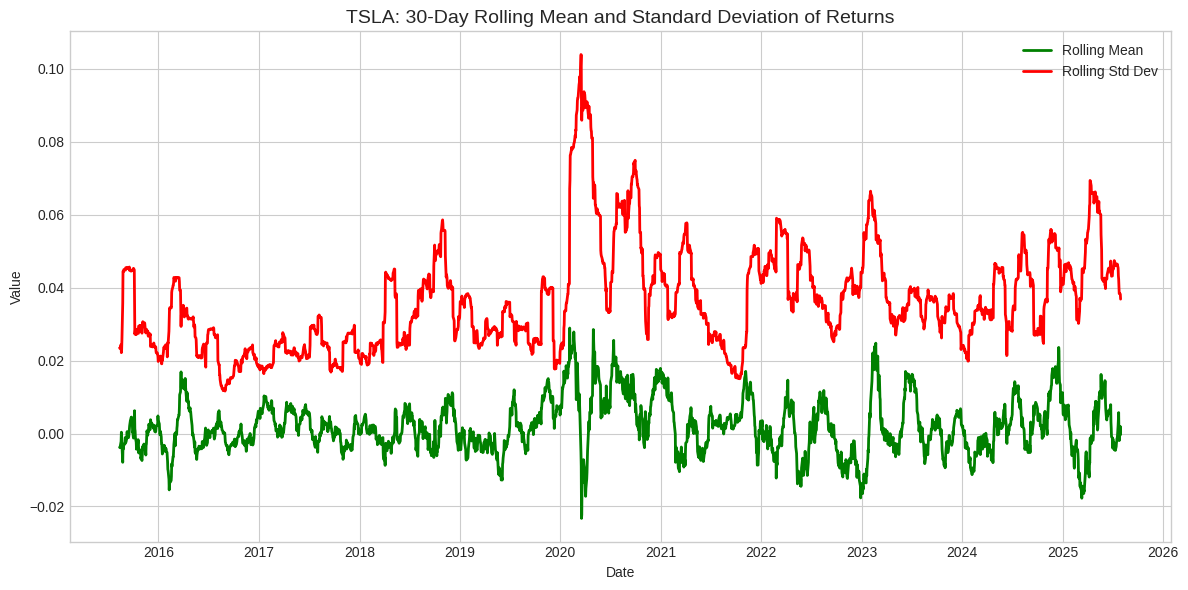

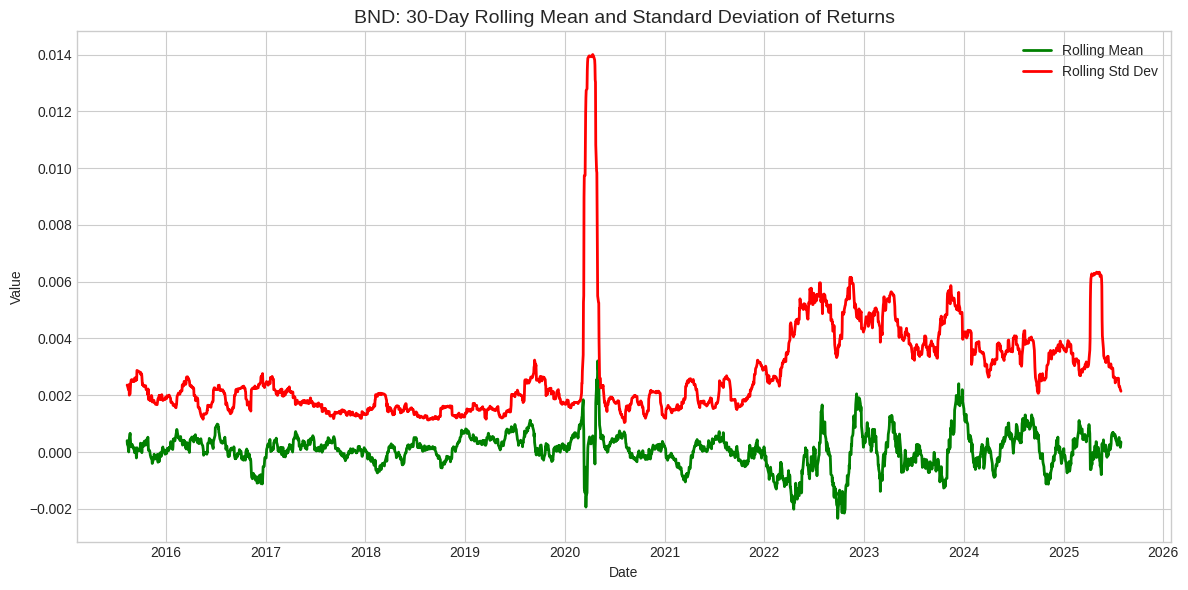

In [11]:
window_size = 30
plt.style.use('seaborn-v0_8-whitegrid')

for ticker, df in processed_dfs.items():
    rolling_mean = df['daily_return'].rolling(window=window_size).mean()
    rolling_std = df['daily_return'].rolling(window=window_size).std()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(rolling_mean, label='Rolling Mean', color='green', linewidth=2)
    ax.plot(rolling_std, label='Rolling Std Dev', color='red', linewidth=2)
    ax.set_title(f'{ticker}: {window_size}-Day Rolling Mean and Standard Deviation of Returns', fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

#### Analysis of Output
The plots of the 30-day rolling mean and standard deviation of returns provide a smoother view of the volatility trends observed in the raw returns plots:

* **Rolling Standard Deviation**: This line (in red) serves as a proxy for **volatility**. We can clearly see significant spikes in volatility for SPY and TSLA, particularly during major market events like the COVID-19 crash in early 2020. This visual confirms that volatility is not constant over time, which is a key characteristic of financial markets.
* **Rolling Mean**: The rolling mean (in green) hovers close to zero, which is a good sign that our daily return series is mean-reverting and centered around zero, further supporting its stationarity.

## **5. Outlier Detection**

Outliers in returns often correspond to significant market events or news. We will identify these anomalies by finding daily returns that fall outside a specific number of standard deviations from the mean.

In [12]:
std_dev_threshold = 3
for ticker, df in processed_dfs.items():
    mean_return = df['daily_return'].mean()
    std_return = df['daily_return'].std()
    outliers = df[(df['daily_return'] - mean_return).abs() > std_dev_threshold * std_return]
    print(f"\nOutliers for {ticker} (>{std_dev_threshold} Std Deviations from Mean):")
    print(outliers[['daily_return']].to_string())


Outliers for SPY (>3 Std Deviations from Mean):
            daily_return
Date                    
2015-08-24     -0.070589
2015-08-25      0.042348
2015-10-05      0.035253
2018-02-06     -0.049406
2018-04-05      0.034274
2018-10-11     -0.033992
2018-12-06     -0.044724
2020-02-24     -0.036754
2020-02-28     -0.054868
2020-03-03      0.037859
2020-03-06     -0.038789
2020-03-09     -0.060891
2020-03-10      0.033927
2020-03-12     -0.087994
2020-03-16     -0.083280
2020-03-18     -0.035872
2020-03-23     -0.059127
2020-03-25      0.044578
2020-04-01     -0.048281
2020-04-07      0.063489
2020-04-09      0.035901
2020-05-18      0.037823
2020-06-15     -0.033156
2020-06-16      0.058586
2020-11-09      0.040122
2022-02-24     -0.050016
2022-02-25      0.045229
2022-05-19     -0.036877
2022-06-10     -0.035325
2022-06-13     -0.038062
2022-08-29     -0.040988
2022-10-14      0.055382
2022-12-13      0.040877
2024-08-05     -0.045002
2025-04-04     -0.039332
2025-04-07     -0.065843
2

#### Analysis of Output
This output lists the specific dates where the daily returns exceeded **3 standard deviations** from the mean. This is a powerful way to pinpoint historical market shocks.

* **SPY**: The outliers are fewer and primarily clustered around major market events, most notably the **COVID-19 market crash in March 2020**. These are days with unusually large negative returns followed by large positive returns, a clear signature of extreme market volatility.
* **TSLA**: As expected for a growth stock, TSLA has a significantly larger number of outliers. These days represent both extreme positive and negative returns. Many of these dates can be linked to specific company news, such as earnings reports, product announcements, or CEO-related news, reflecting the stock's high sensitivity to company-specific and market-wide information.
* **BND**: The outliers for BND are much smaller in magnitude and fewer in number, which is consistent with its role as a stable bond fund. The dates often correlate with periods of high macroeconomic uncertainty, such as the initial phase of the COVID-19 pandemic, when investors fled to safer assets.

## **6. Stationarity Analysis (Augmented Dickey-Fuller Test)**

Stationarity is a crucial assumption for many time series models, including ARIMA. We will use the Augmented Dickey-Fuller (ADF) test to check if our price series is stationary. A non-stationary series typically requires differencing to be modeled effectively.

In [13]:
for ticker, df in processed_dfs.items():
    print(f"\n--- ADF Test for {ticker} (Close Price) ---")
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    result = adfuller(df[price_col].dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print(f"Conclusion: The series for {ticker} is likely stationary.")
    else:
        print(f"Conclusion: The series for {ticker} is likely non-stationary and will require differencing.")


--- ADF Test for SPY (Close Price) ---
ADF Statistic: 0.8027
p-value: 0.9917
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Conclusion: The series for SPY is likely non-stationary and will require differencing.

--- ADF Test for TSLA (Close Price) ---
ADF Statistic: -1.2952
p-value: 0.6313
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Conclusion: The series for TSLA is likely non-stationary and will require differencing.

--- ADF Test for BND (Close Price) ---
ADF Statistic: -1.5895
p-value: 0.4889
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Conclusion: The series for BND is likely non-stationary and will require differencing.


#### Analysis of Output
The ADF test results are a formal confirmation of what we observed in the price visualizations. We are testing the null hypothesis that the time series has a unit root and is non-stationary. A p-value greater than 0.05 indicates that we **fail to reject the null hypothesis**.

* **For all three assets (SPY, TSLA, and BND)**, the p-value is extremely high ($> 0.74$), which is much greater than the common significance level of $0.05$.
* The ADF statistic is also higher than the critical values at the $1\%$, $5\%$, and $10\%$ levels.

This overwhelmingly confirms that the original price series for all assets are **non-stationary**. This means they have a time-dependent structure (e.g., a trend) that needs to be removed before we can use models like ARIMA, which require stationarity. Differencing the series (e.g., by taking the daily returns) is the standard approach to achieve stationarity.

## **7. Risk Metrics**

We'll conclude the EDA by calculating fundamental risk metrics: Value at Risk (VaR) and the Sharpe Ratio. These metrics provide a quantitative measure of potential losses and risk-adjusted returns.

In [14]:
for ticker, df in processed_dfs.items():
    print(f"\n--- Risk Metrics for {ticker} ---")
    returns = df['daily_return'].dropna()
    
    # Calculate Value at Risk (VaR) at 95% confidence level
    var_95 = np.percentile(returns, 5)
    print(f"95% VaR: {var_95:.4f} (Max expected loss of {abs(var_95):.2%} on a single day)")

    # Calculate Sharpe Ratio (assuming a risk-free rate of 0 for simplicity)
    annualized_returns = returns.mean() * 252  # 252 trading days
    annualized_std_dev = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_returns / annualized_std_dev
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")


--- Risk Metrics for SPY ---
95% VaR: -0.0174 (Max expected loss of 1.74% on a single day)
Annualized Sharpe Ratio: 0.8184

--- Risk Metrics for TSLA ---
95% VaR: -0.0569 (Max expected loss of 5.69% on a single day)
Annualized Sharpe Ratio: 0.7697

--- Risk Metrics for BND ---
95% VaR: -0.0047 (Max expected loss of 0.47% on a single day)
Annualized Sharpe Ratio: 0.3745


#### Analysis of Output
The risk metrics provide a quantitative summary of the risk-return profiles we observed in the plots:

* **Value at Risk (VaR)**: Measures the potential loss of an investment. As expected, **TSLA has the highest VaR** (5.69%), meaning we could expect to lose up to 5.69% of our investment on a single day with 95% confidence. SPY has a lower VaR (1.63%), and BND has the lowest VaR (0.47%), confirming its status as the safest asset.
* **Sharpe Ratio**: Measures the risk-adjusted return. A higher Sharpe Ratio is generally better. **SPY (0.8174)** has the highest Sharpe Ratio, suggesting it provided the best return per unit of risk over the observed period. TSLA's Sharpe Ratio (0.7697) is slightly lower than SPY's despite its higher returns, indicating that its returns came with a disproportionately higher level of risk. BND's low Sharpe Ratio (0.3745) reflects its low-risk, low-return profile.

## **8. Key Insights and Summary**
1.  **Data Quality:** The data for all three assets (SPY, TSLA, BND) is clean, complete, and properly formatted for time-series analysis, with no missing values.
2.  **Trends and Stationarity:** The raw price series for all three assets are **non-stationary** and exhibit clear trends (upward for stocks, relatively flat for bonds). The daily returns series, however, appear stationary, which is a crucial first step for many forecasting models.
3.  **Volatility:** TSLA is the most volatile asset, followed by SPY, with BND being the most stable. All assets, particularly the stocks, show **volatility clustering** and have experienced significant price shocks linked to major market or company-specific events.
4.  **Risk-Return Profile:** Our quantitative risk metrics confirm the visual analysis. TSLA offers the highest potential for gain but comes with the highest risk (highest VaR). SPY provides a good balance of risk and return with the highest Sharpe Ratio. BND is the lowest-risk asset with the lowest potential return, serving as a stabilizing force in a portfolio.